In [78]:
from matplotlib import pyplot as plt

import numpy as np
import shapely
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
from osmnx import features as ox_features
from osmnx import geocode_to_gdf as geocode_to_gdf
from osmnx import projection as ox_projection
from typing import List, Tuple
import math
from shapely import Point
import random

from vertiport import Vertiport
#FIX:
# this module will now handle creating objects in/on airspace
# vertiport creation
# restricted airspace creation
#  
class Airspace:
    def __init__(self, number_of_vertiports, location_name: str, buffer_radius: float = 500, airspace_tag_list=[], max_vertiports=25) -> None:   #! airspace feature has to be list of strings
        """Airspace - Defines the location of the map. Imports key information on hopitals(no fly zone)

        Args:
            location_name (string): Location of the Airspace ie. "Austin, Texas, USA"
            buffer_radius (int): distance around hospitals

        Attributes:
            location_name(string): Location of the Airspace ie. "Austin, Texas, USA"
            buffer_radius (int): distance around hospitals
            location_utm_gdf (gdp.GeoDataFrame): Location in UTM(Universal Transverse Mercator)
            location_utm_hospital ( ox_projection): location of hospital converted to UTM
            location_utm_hospital_buffer (UTM): buffer around the hospital
        """
        self.location_name = location_name  #'Austin, Texas, USA'
        self.buffer_radius = buffer_radius
        self.airspace_tag_list = airspace_tag_list

        # location - this is the airspace where we are working 
        location_gdf = geocode_to_gdf(location_name)  # converts named geocode - 'Austin,Texas' location to gdf
        self.location_utm_gdf: gpd.GeoDataFrame = ox_projection.project_gdf(location_gdf)  # default projection - UTM projection #! GeoDataFrame has deprication warning - need quick fix
        self.location_utm_gdf["boundary"] = (self.location_utm_gdf.boundary)  # adding column 'boundary'
        
        # airspace features and restricted airspace 
        self.location_tags = {}
        self.location_feature = {}
        self.location_utm = {}
        self.location_utm_buffer = {}
        
        self.airspace_restricted_area_buffer_array = []
        self.airspace_restricted_area_array = []
        
        for tag, tag_value in self.airspace_tag_list:
            self.location_tags[tag_value] = tag
            self.location_feature[tag_value] = ox_features.features_from_polygon(location_gdf["geometry"][0], tags={tag:tag_value})
            self.location_utm[tag_value] = ox_projection.project_gdf(self.location_feature[tag_value])
            self.location_utm_buffer[tag_value] = self.location_utm[tag_value].buffer(self.buffer_radius)
            self.airspace_restricted_area_array.append(self.location_utm[tag_value])
            self.airspace_restricted_area_buffer_array.append(self.location_utm_buffer[tag_value])
        
        self.restricted_airspace_buffer_geo_series = pd.concat(self.airspace_restricted_area_buffer_array)
        self.restricted_airspace_geo_series = pd.concat(self.airspace_restricted_area_array)


        # Vertiport
        self.number_of_vertiports = number_of_vertiports
        self.vertiport_list:List = []
        self.max_vertiports = max_vertiports 
        self.polygon_dict = {}

    def __repr__(self) -> str:
        return "Airspace({location_name})".format(location_name=self.location_name)

    def set_vertiport(self,vertiport):
        """
        Adds a vertiport to the vertiport list.

        Args:
            vertiport: The vertiport to add.
        
        Returns:
            None
        """
        if len(self.vertiport_list) < self.max_vertiports:
            self.vertiport_list.append(vertiport)
        else:
            print('Max number of vertiports reached, additonal vertiports will not be added')
        return None 
    
    def get_vertiport_list(self):
        """
        Returns the list of vertiports.

        Returns:
            List: The list of vertiports.
        """
        return self.vertiport_list

    def create_n_random_vertiports(self, num_vertiports: int, seed = None) -> None:
        """
        Creates a specified number of random vertiports within the airspace.

        Args:
            num_vertiports (int): The number of vertiports to create.

        Returns:
            None

        Side Effects:
            - Creates the vertiports and updates the vertiports in the airspace list.
        """

        # Set seed if provided
        if seed is not None:
            print(f"Creating vertiports with seed: {seed}")
            random.seed(seed)
            np.random.seed(seed)

        if num_vertiports > self.number_of_vertiports:
            raise RuntimeError('Exceeds vertiport number defined for initialization')

        for tag_value in self.location_tags.keys():
            sample_space = self.location_utm_gdf.iloc[0,0].difference(
                self.location_utm_buffer[tag_value].unary_union
            )

        sample_space_gdf = GeoSeries(sample_space)
        sample_vertiport: GeoSeries = sample_space_gdf.sample_points(num_vertiports, seed=seed)
        sample_vertiport_array: np.ndarray = shapely.get_parts(sample_vertiport[0])

        for location in sample_vertiport_array:
            self.vertiport_list.append(
                Vertiport(location=location, uav_list=[])
            )

        print(f"Created {len(self.vertiport_list)} vertiports with seed {seed}")

    def create_vertiport_at_location(self, position:Tuple)-> None:
        """Create a vertiport at position(x,y)."""
        position = Point(position[0], position[1])
        
        for tag_value in self.location_tags.keys():
            sample_space = self.location_utm_gdf.iloc[0,0].difference(
                self.location_utm_buffer[tag_value].unary_union
            )

        sample_space_gdf = GeoSeries(sample_space)
        sample_space_array: np.ndarray = shapely.get_parts(sample_space_gdf)

        for sample in sample_space_array:
            if sample.contains(position):
                print('Valid location for vertiport')
                _vertiport = Vertiport(position)
                return _vertiport
        
        print('Not a valid position for vertiport')
        
    
    def create_vertiport_from_polygon(self,polygon:shapely.Polygon) -> Vertiport:
        '''Given a polygon, find the centeroid of the polygon, 
        and place a vertiport at that polygon'''
        poly_centeroid = polygon.centroid
        return Vertiport(poly_centeroid)
        

    def create_vertiports_from_polygons(self,polygon_list:List[shapely.Polygon]):
        '''Use polygons from polygon_list to place vertiports at each polygon'''
        vertiport_list = []
        for polygon in polygon_list:
            vertiport_list.append(self.create_vertiport_from_polygon(polygon))
        return vertiport_list
        

    def make_polygon_dict(self, tag_str):
        
        #TODO: check if tag_str in tag_list
        # if True, then use tag_str as key for dict

        self.polygon_dict[tag_str] = [obj for obj in self.location_utm[tag_str].geometry if isinstance(obj, shapely.Polygon)]

        return None 






    





    




In [74]:
airspace = Airspace(12,
                    "Austin, Texas, USA",
                    airspace_tag_list=[
                                        ("building", "commercial"),
                                        ("building", "hotel"),
                                        ("building", "residential"),
                                        ("building", "industrial"),
                                        ("building", "office"),
                                        ("building", "retail"),
                                        ("building", "civic"),
                                        ("building", "college"),
                                        ("building", "government"),
                                        ("building", "public"),
                                        ("building", "school"),
                                        ("building", "train_station"),
                                        ("building", "transportation"),
                                        ("building", "university")
                                        ]
)


airspace.make_polygon_dict('commercial')
airspace.polygon_dict['commercial']
poly_list = airspace.create_vertiports_from_polygons(airspace.polygon_dict['commercial'])
sample_poly_list = random.sample(poly_list, 3)
sample_poly_list



/Users/aadit/miniconda3/envs/AAM/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/aadit/miniconda3/envs/AAM/lib/python3.11/site-packages/shapely/set_operations.py:334: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/aadit/miniconda3/envs/AAM/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/aadit/miniconda3/envs/AAM/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/aadit/miniconda3/envs/AAM/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/aadit/miniconda3/envs/AAM/lib/python3.11/site-packages/shapely/predicates.

[Vertiport(POINT (616138.6059414379 3369685.4047019104), []),
 Vertiport(POINT (621314.1576930188 3340816.323672102), []),
 Vertiport(POINT (622983.5142465468 3351771.238380259), [])]

/Users/aadit/miniconda3/envs/AAM/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/aadit/miniconda3/envs/AAM/lib/python3.11/site-packages/shapely/set_operations.py:334: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/aadit/miniconda3/envs/AAM/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/aadit/miniconda3/envs/AAM/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/aadit/miniconda3/envs/AAM/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/aadit/miniconda3/envs/AAM/lib/python3.11/site-packages/shapely/predicates.

TAG VALUE: commercial, 506
TAG VALUE: hotel, 19
TAG VALUE: residential, 165
TAG VALUE: industrial, 124
TAG VALUE: office, 236
TAG VALUE: retail, 640
TAG VALUE: civic, 1
TAG VALUE: college, 24
TAG VALUE: government, 63
TAG VALUE: public, 44
TAG VALUE: school, 456
TAG VALUE: train_station, 1
TAG VALUE: transportation, 2
TAG VALUE: university, 205


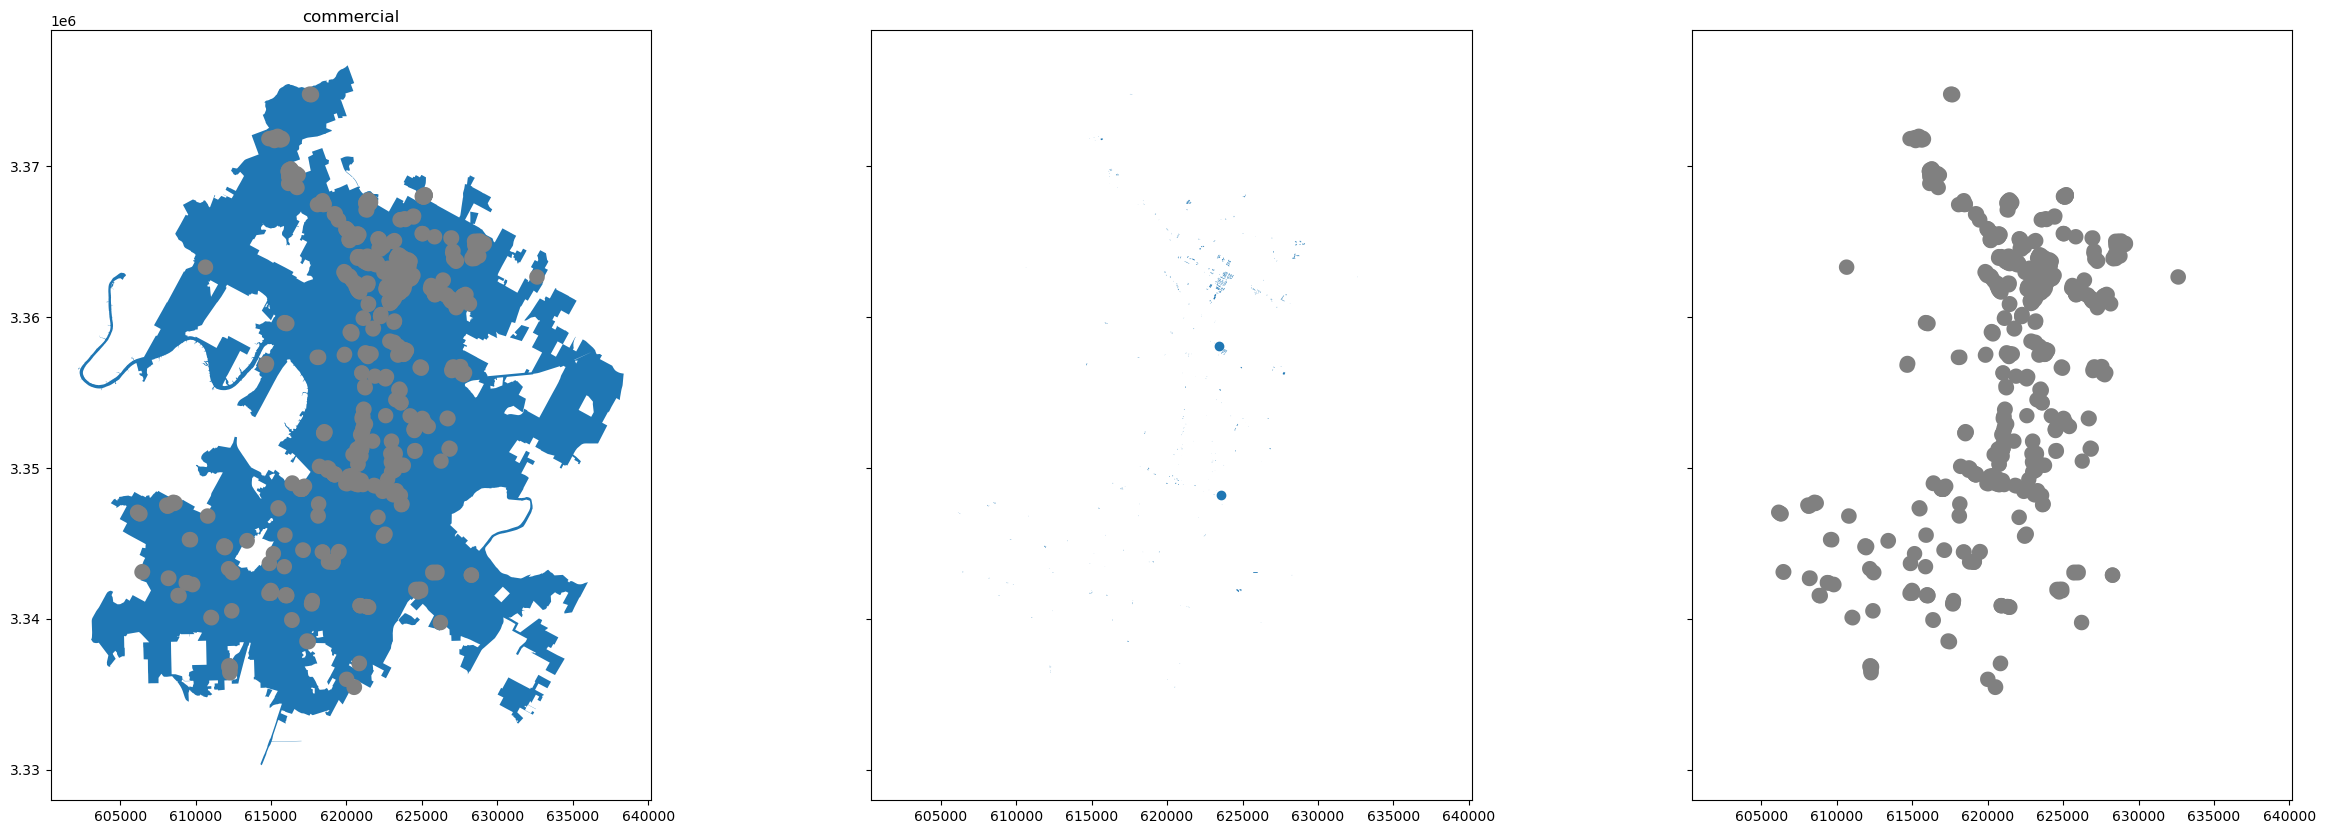

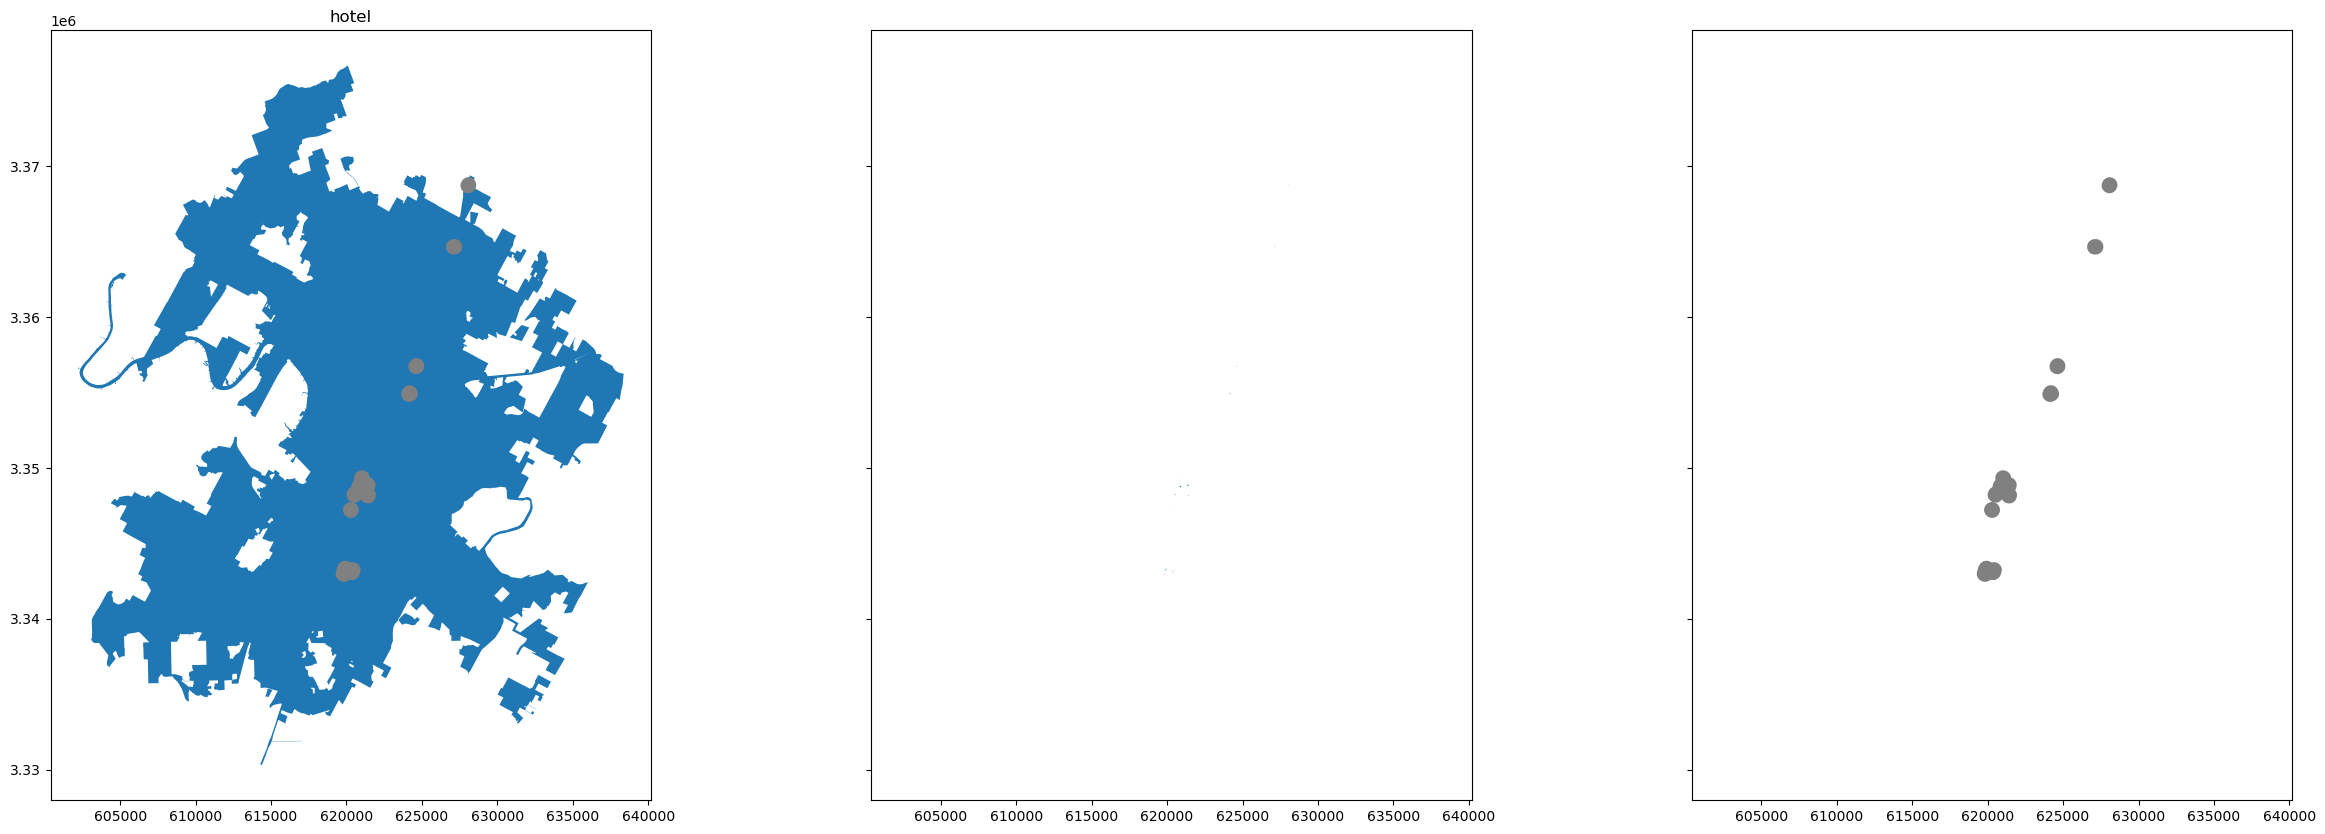

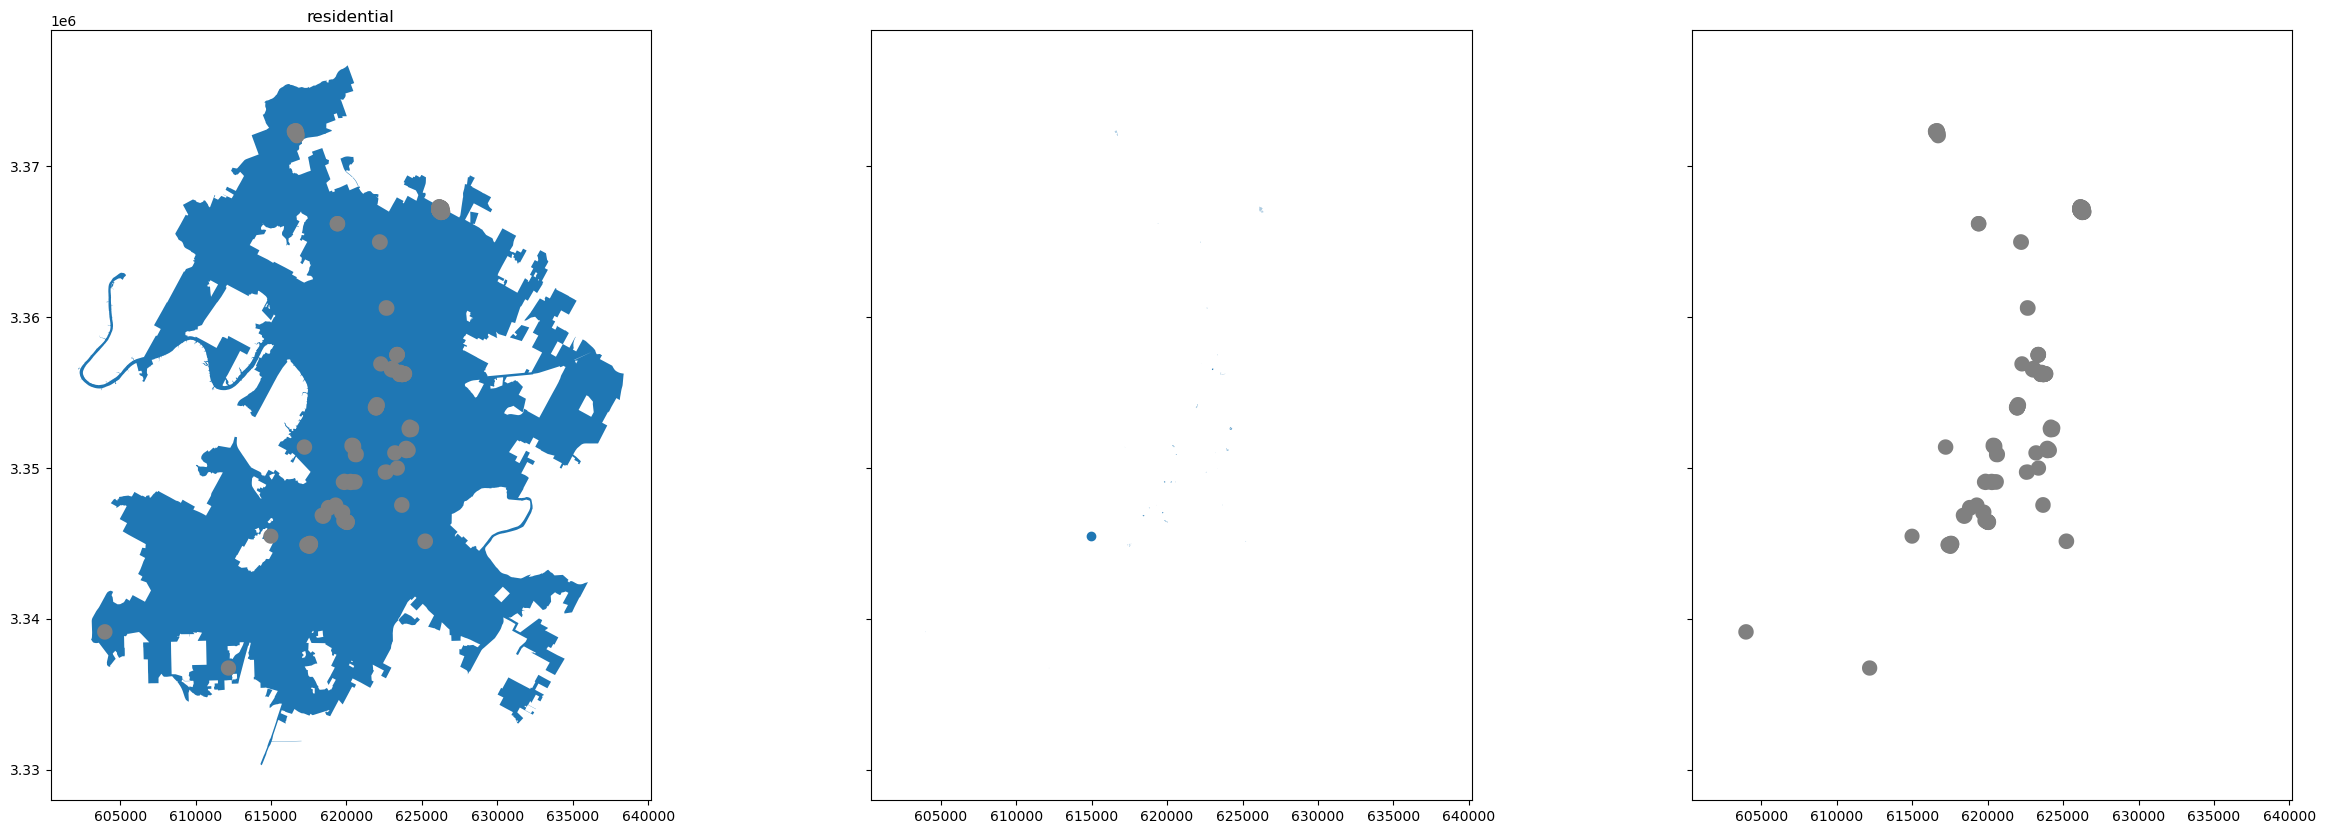

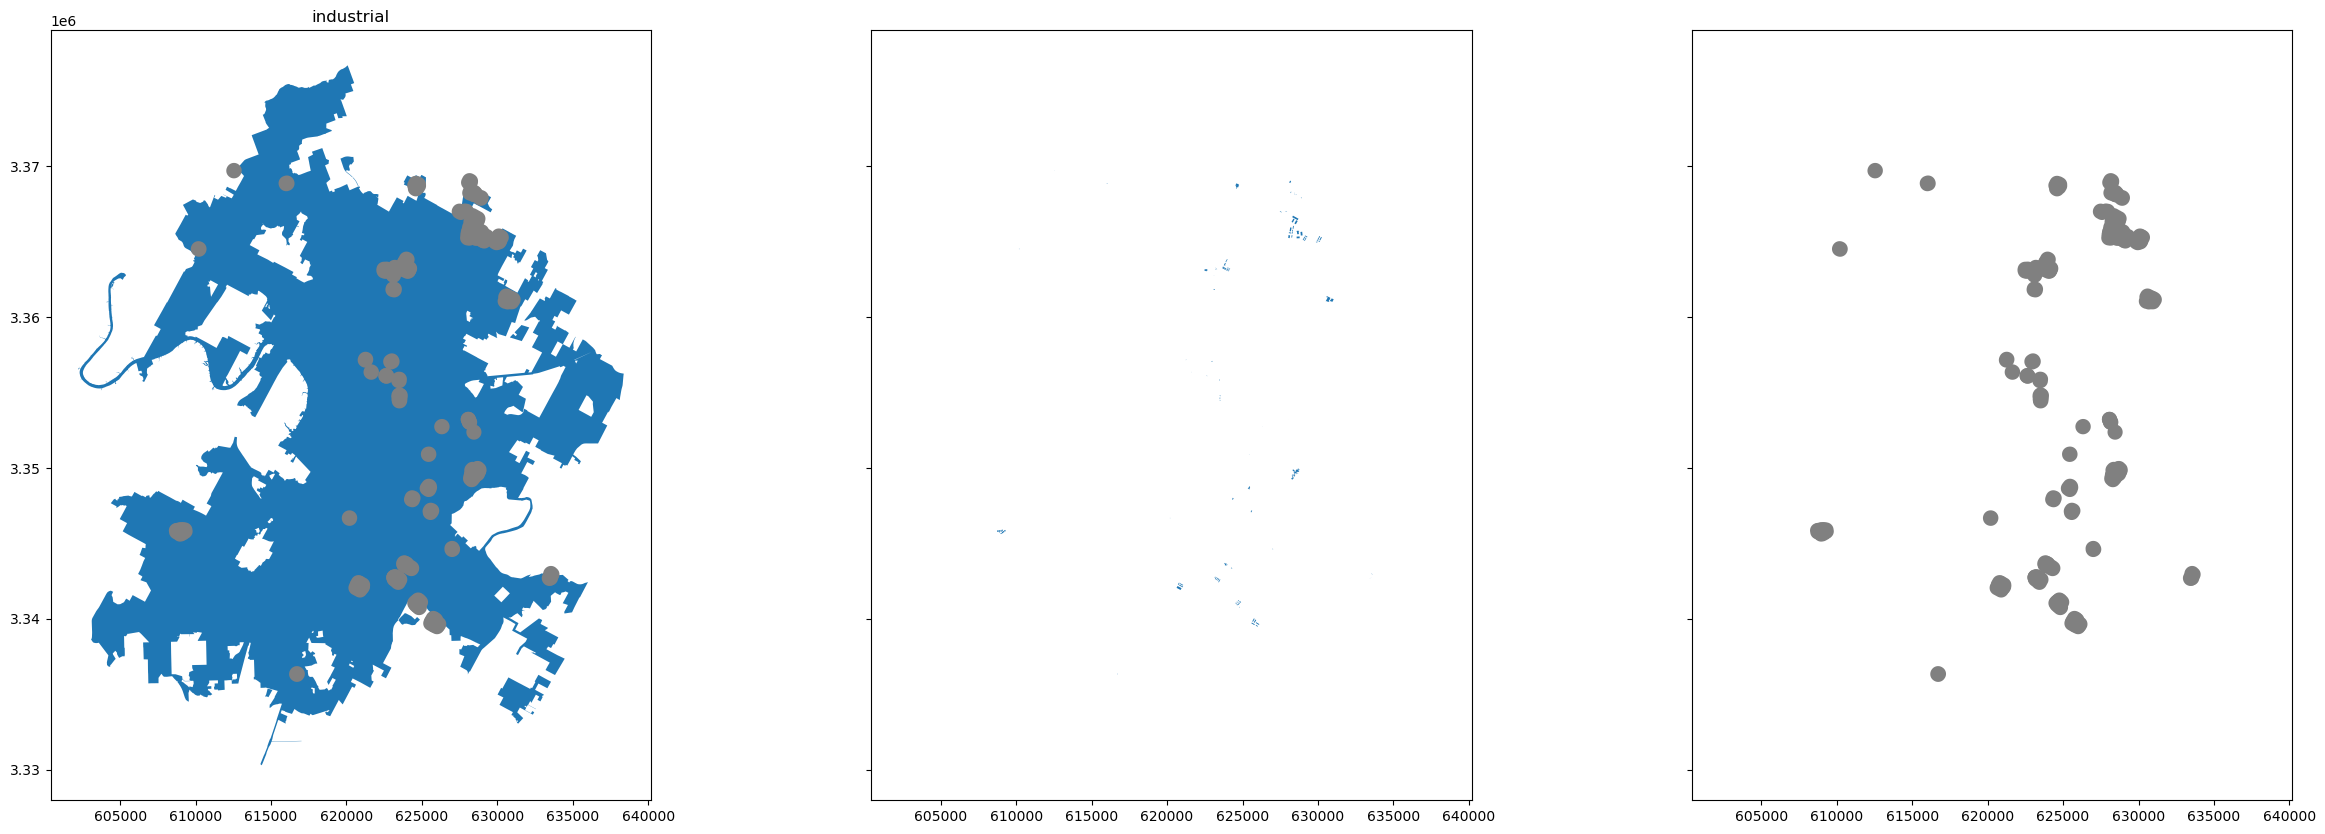

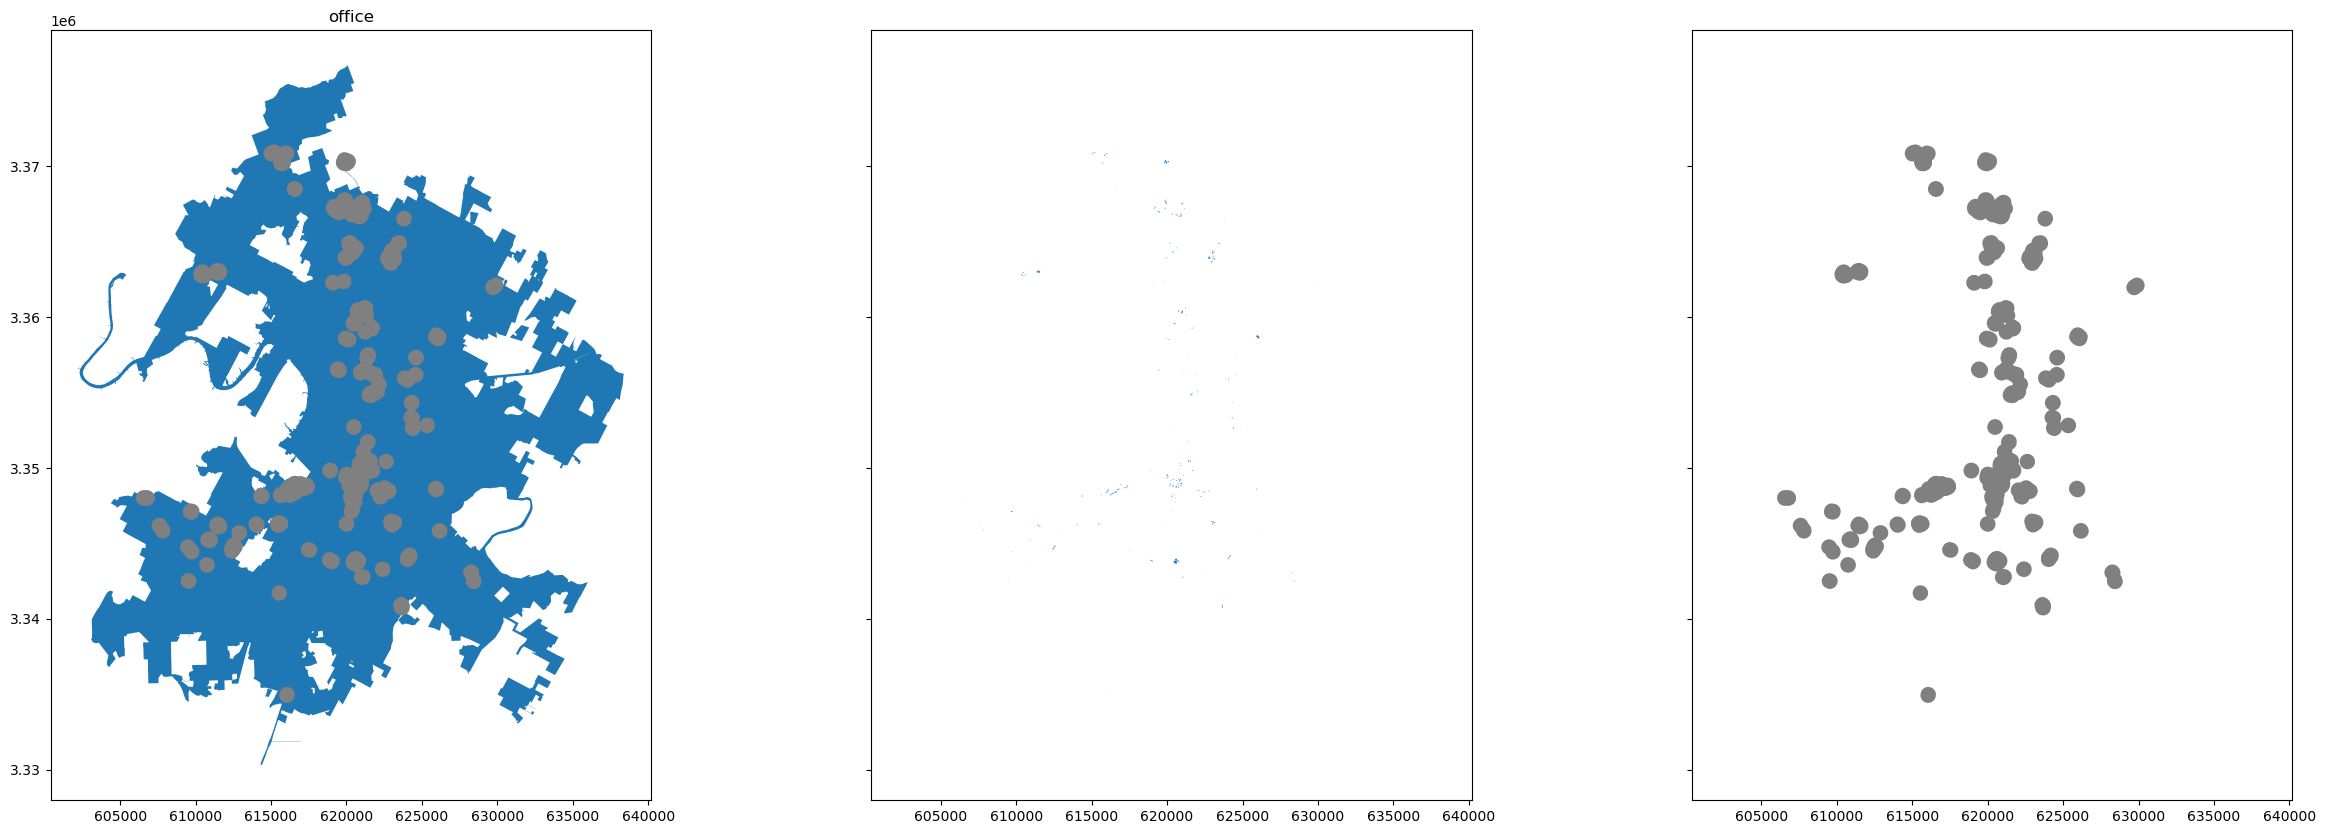

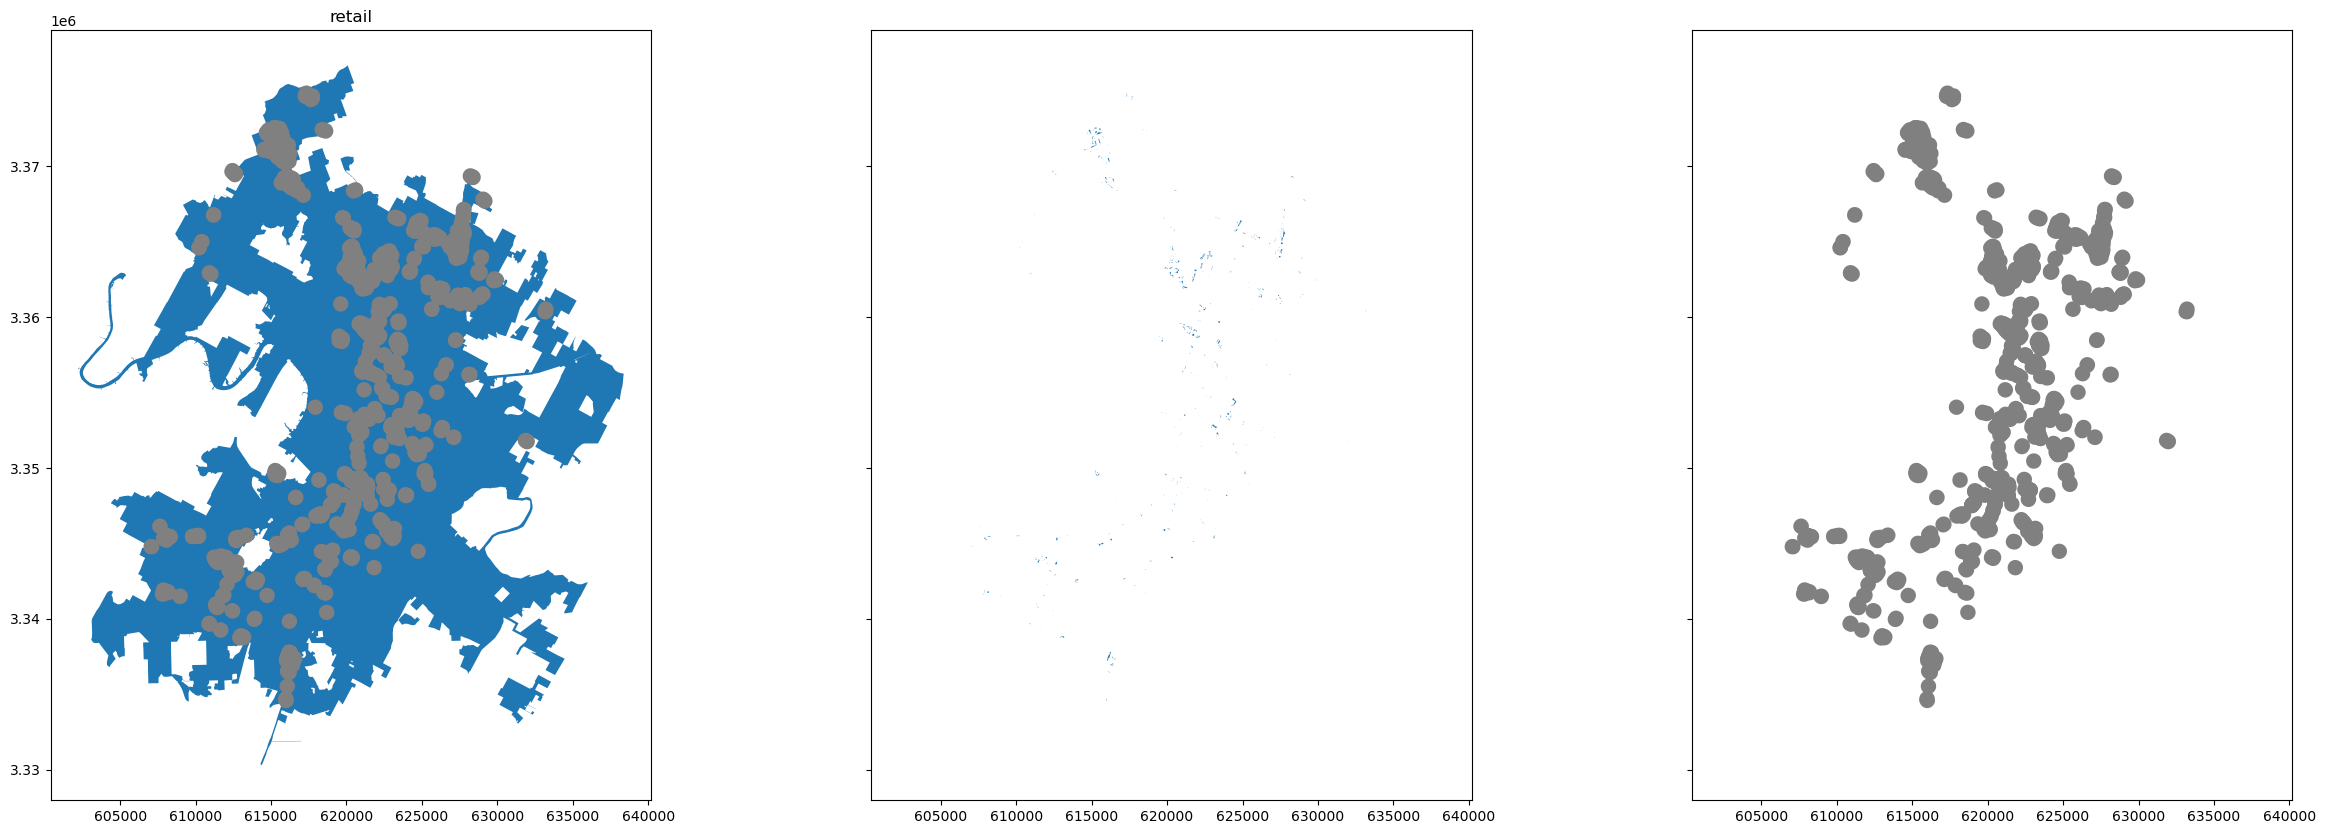

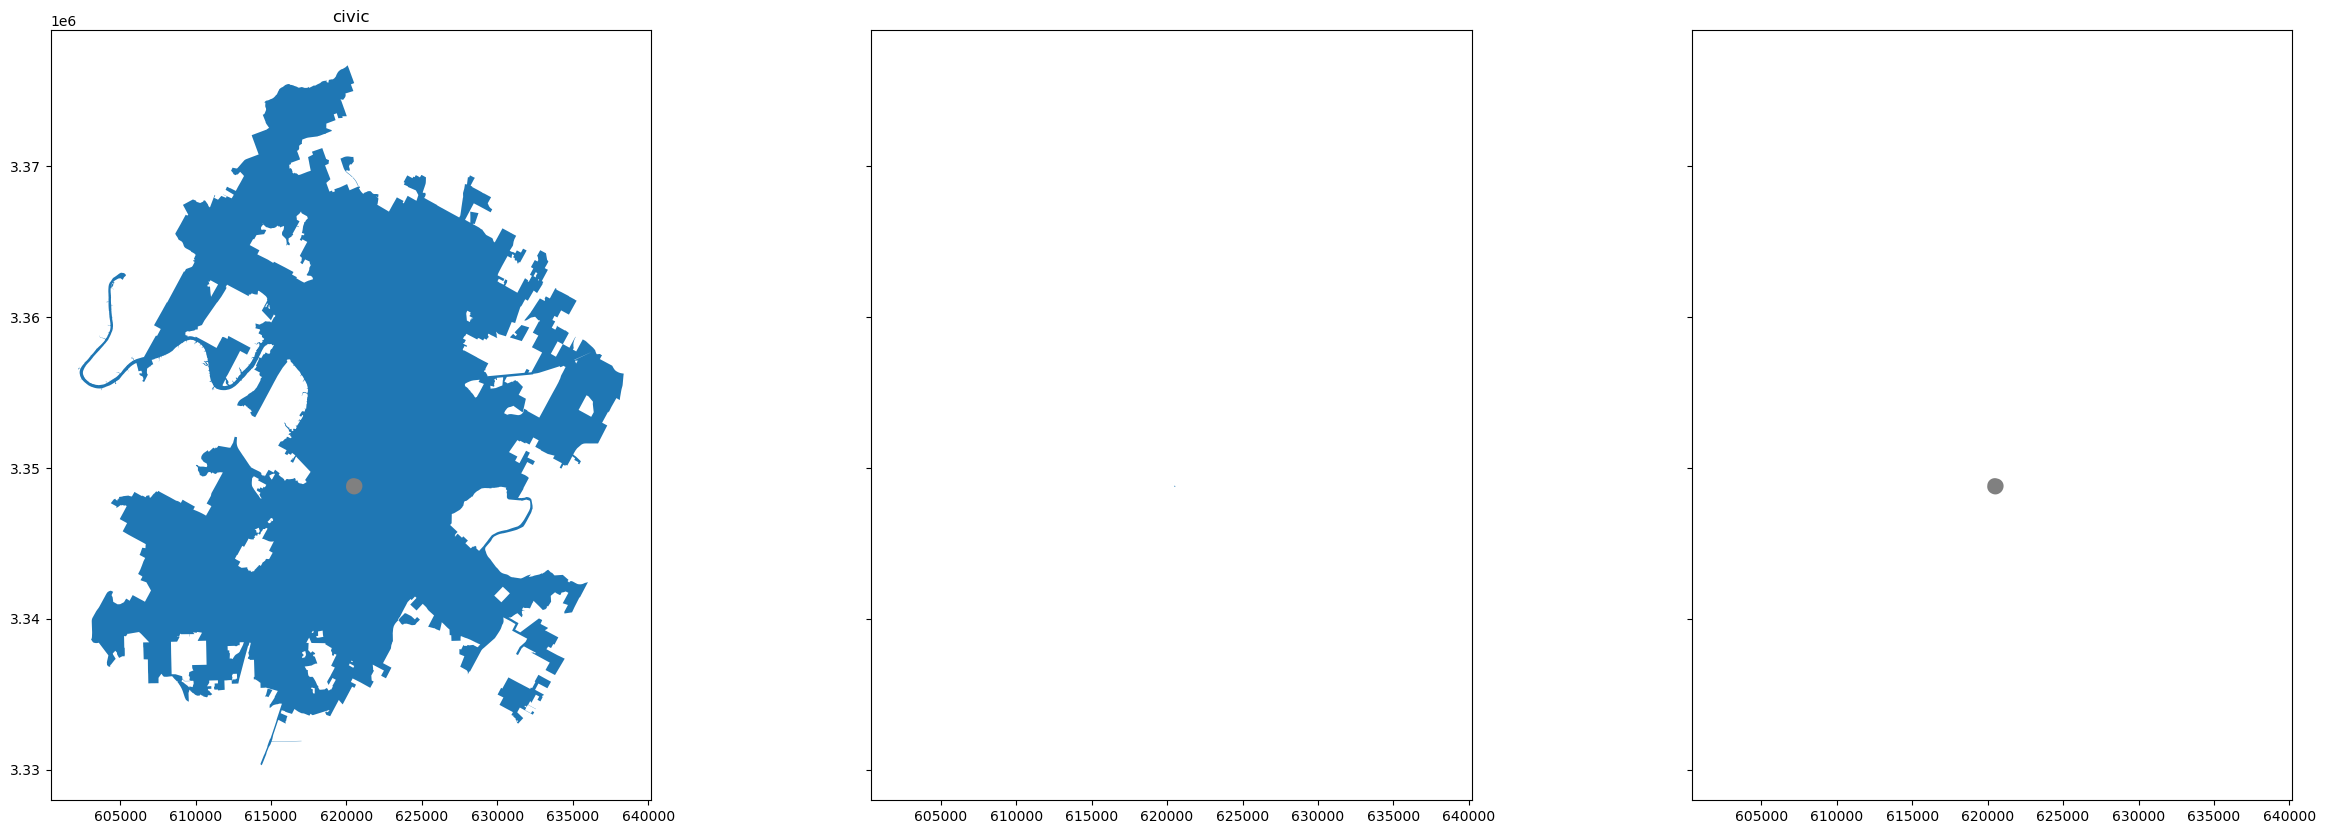

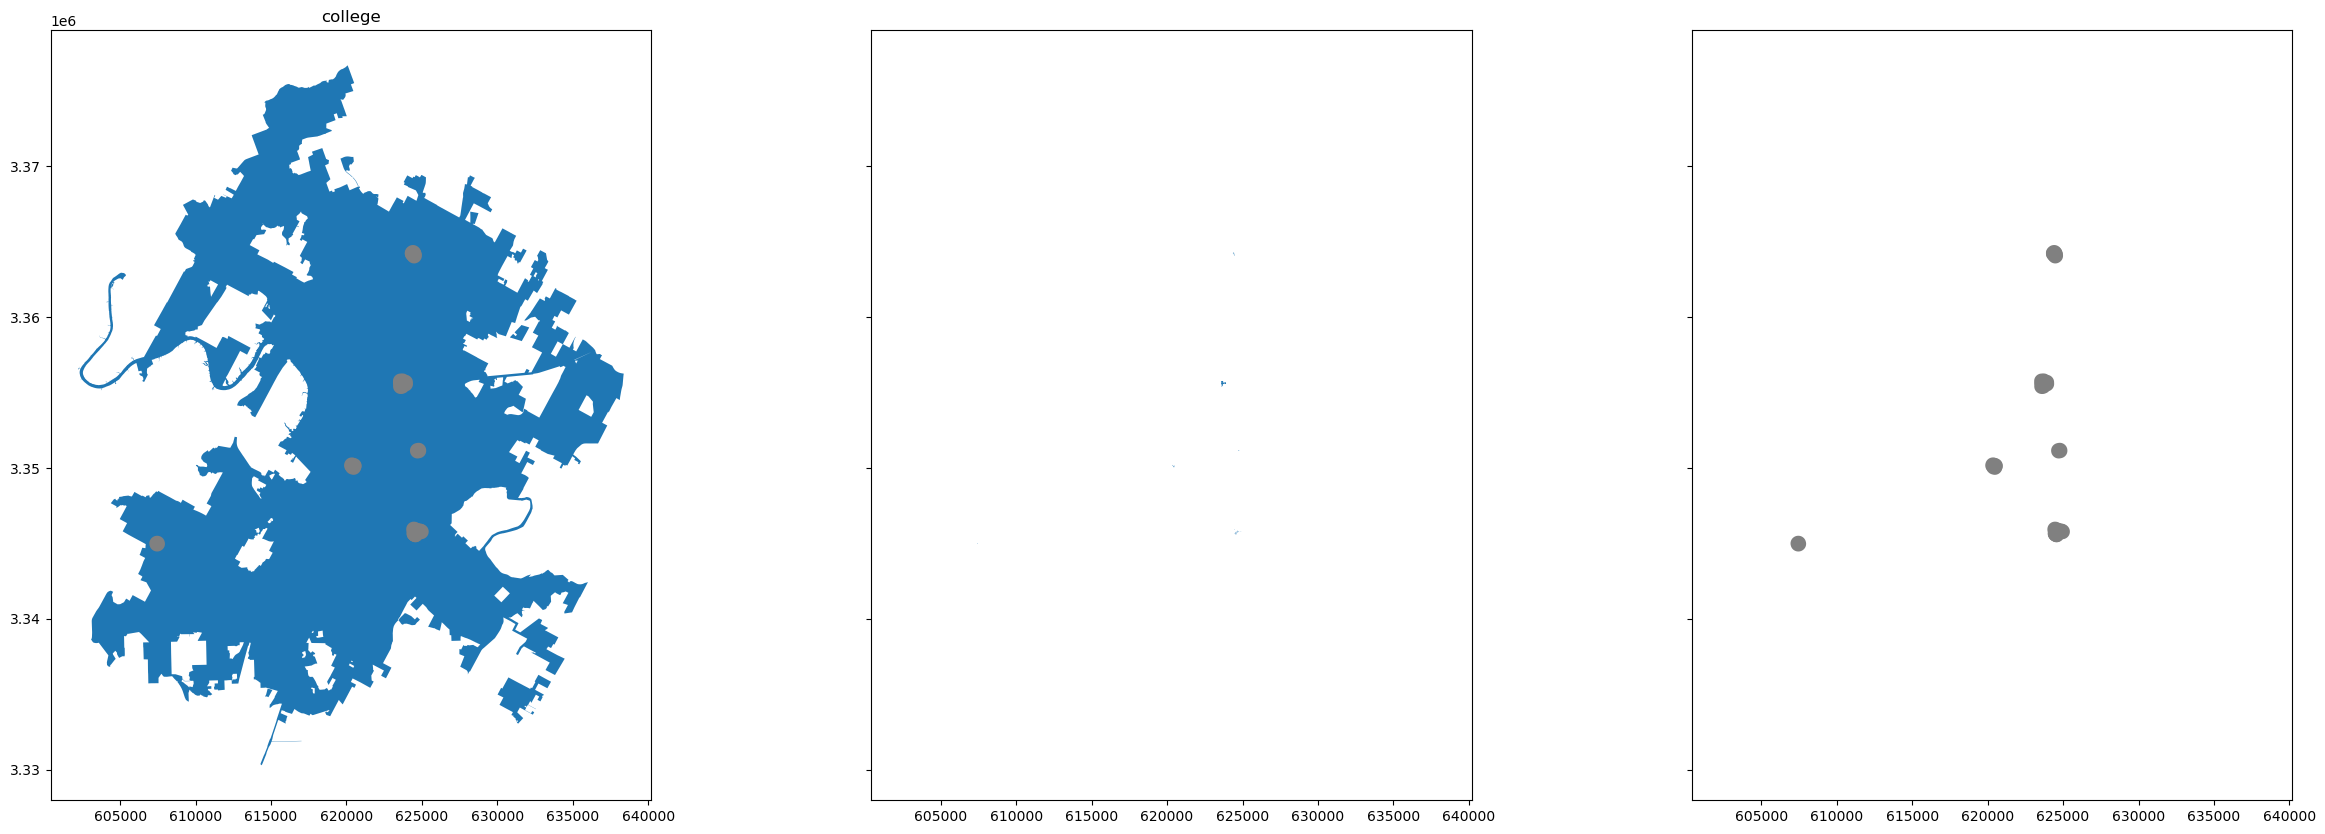

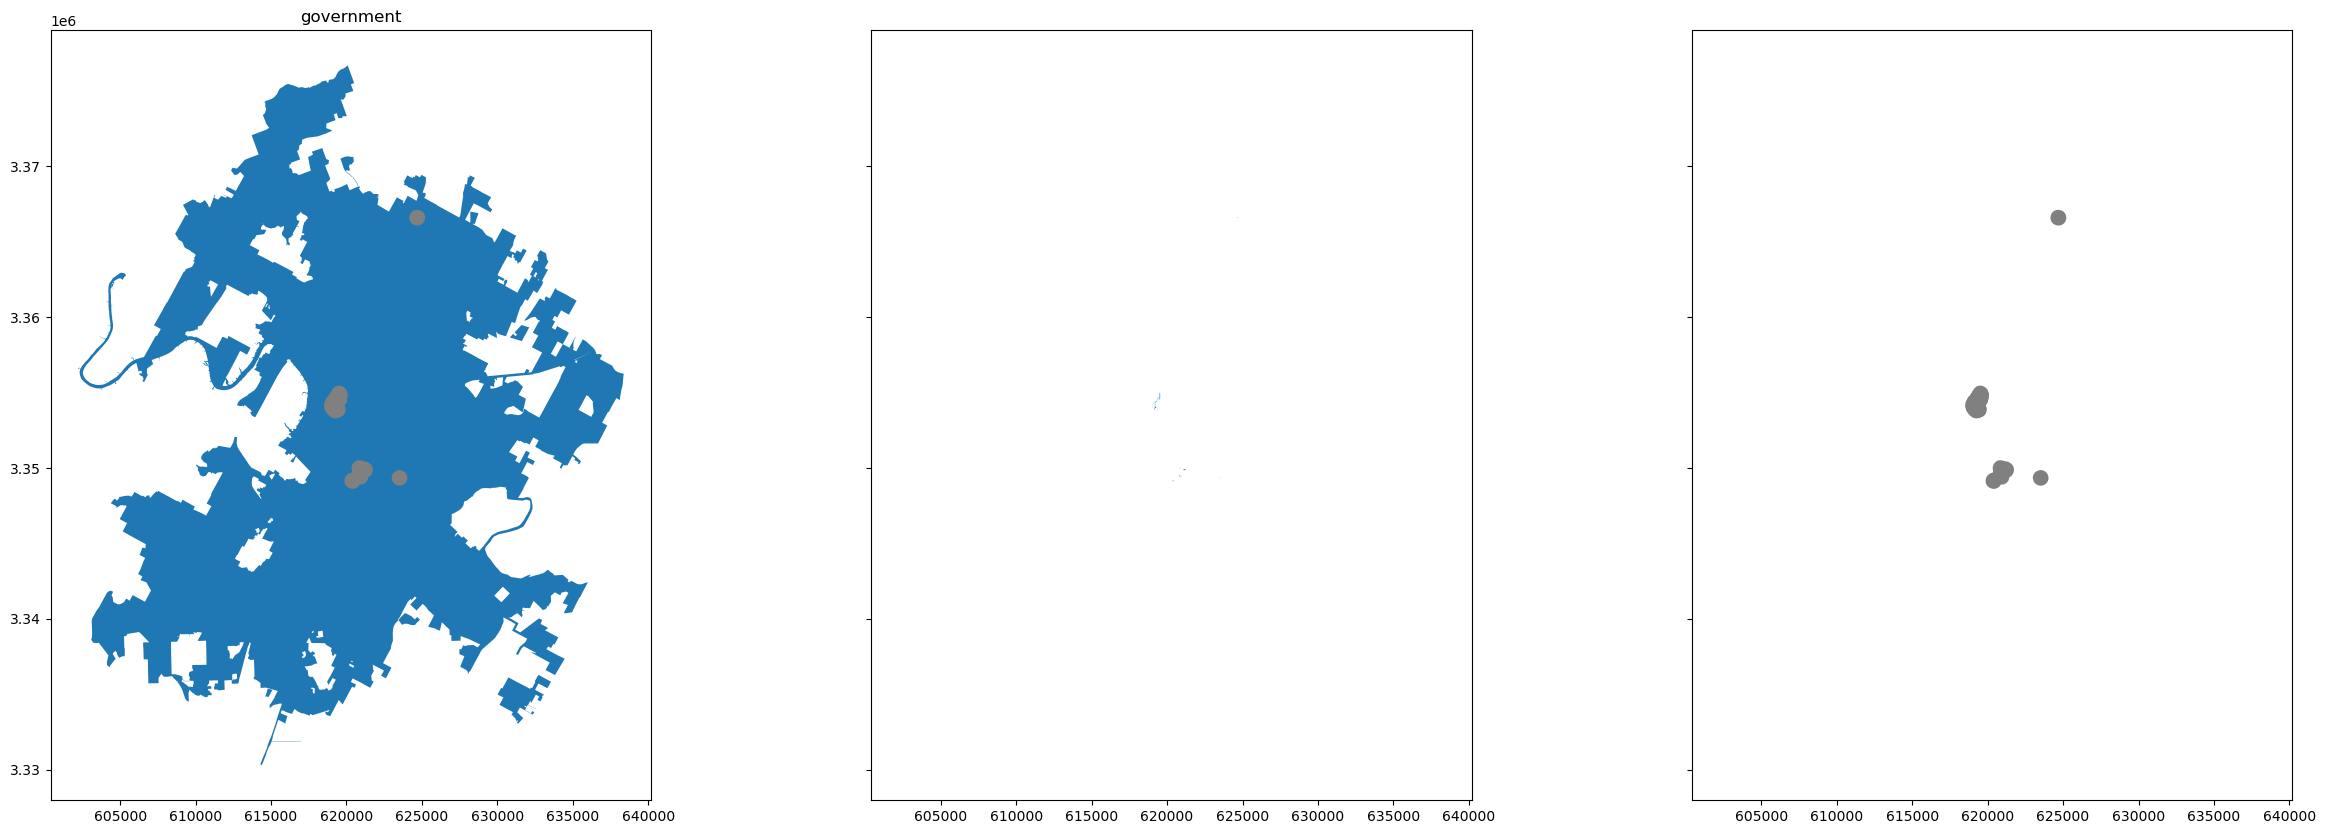

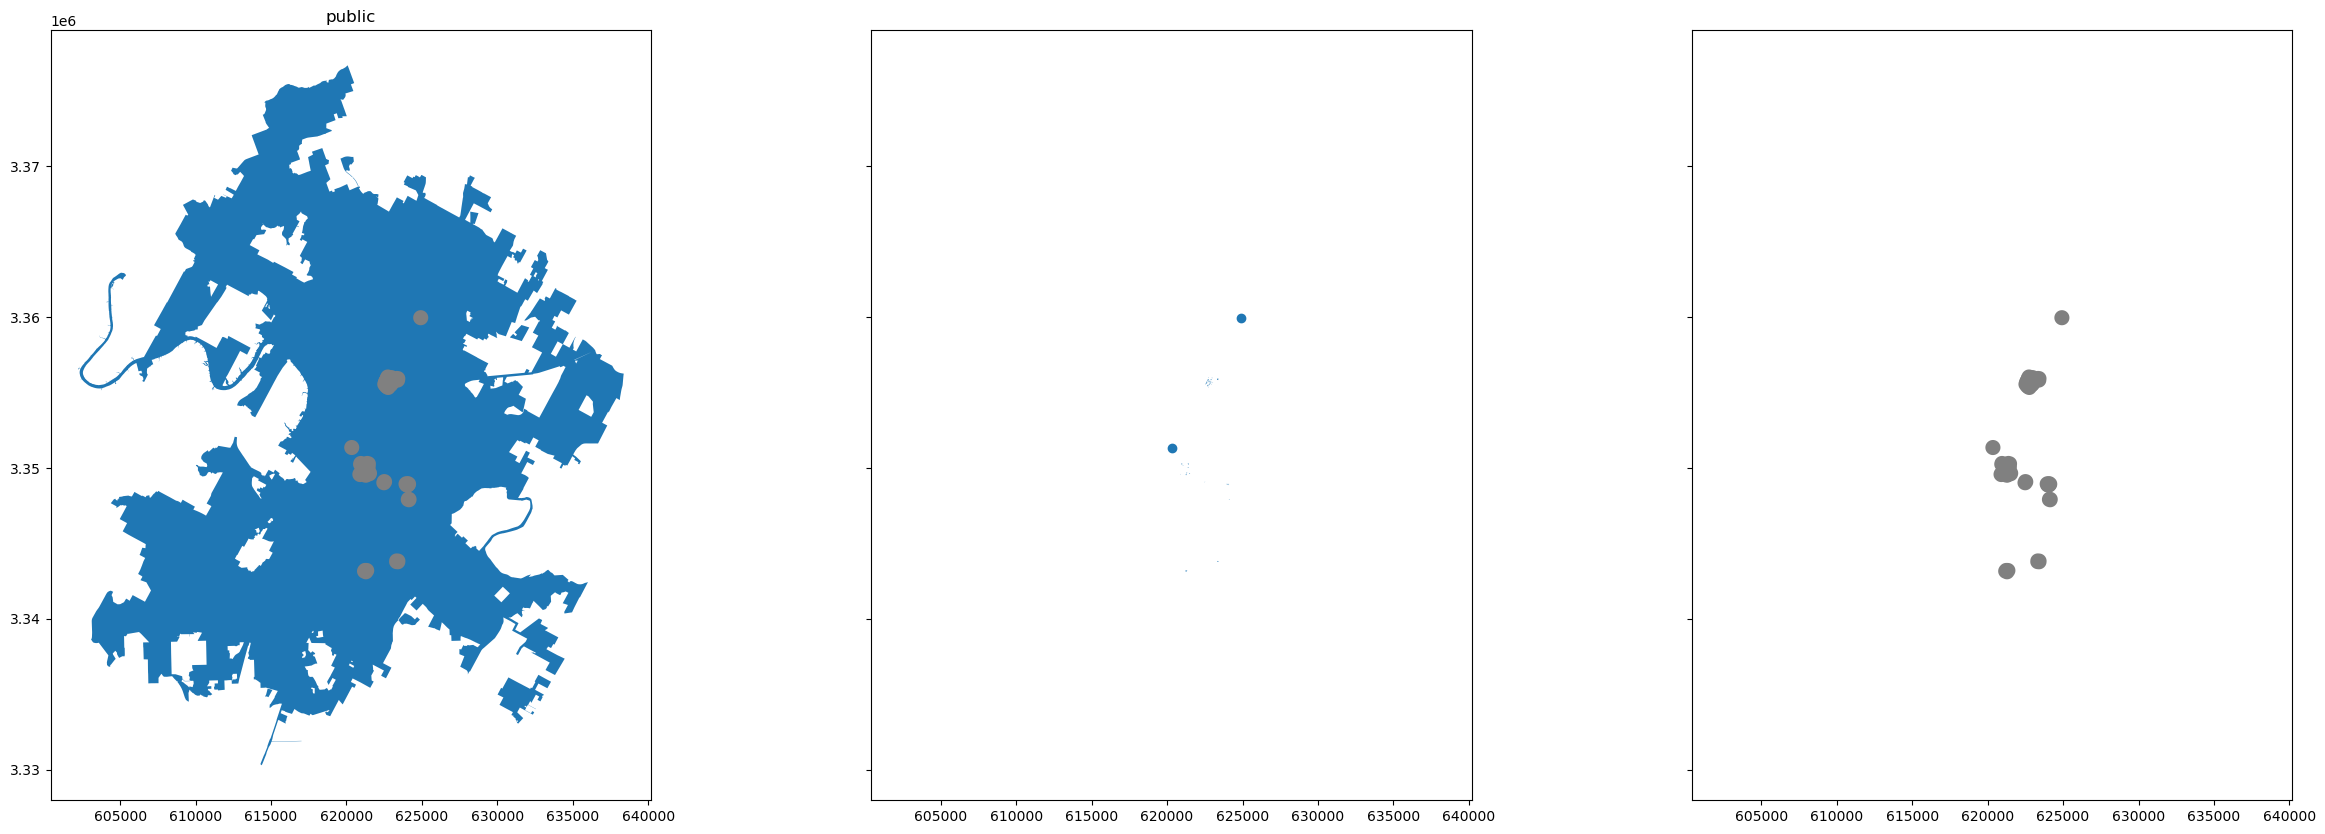

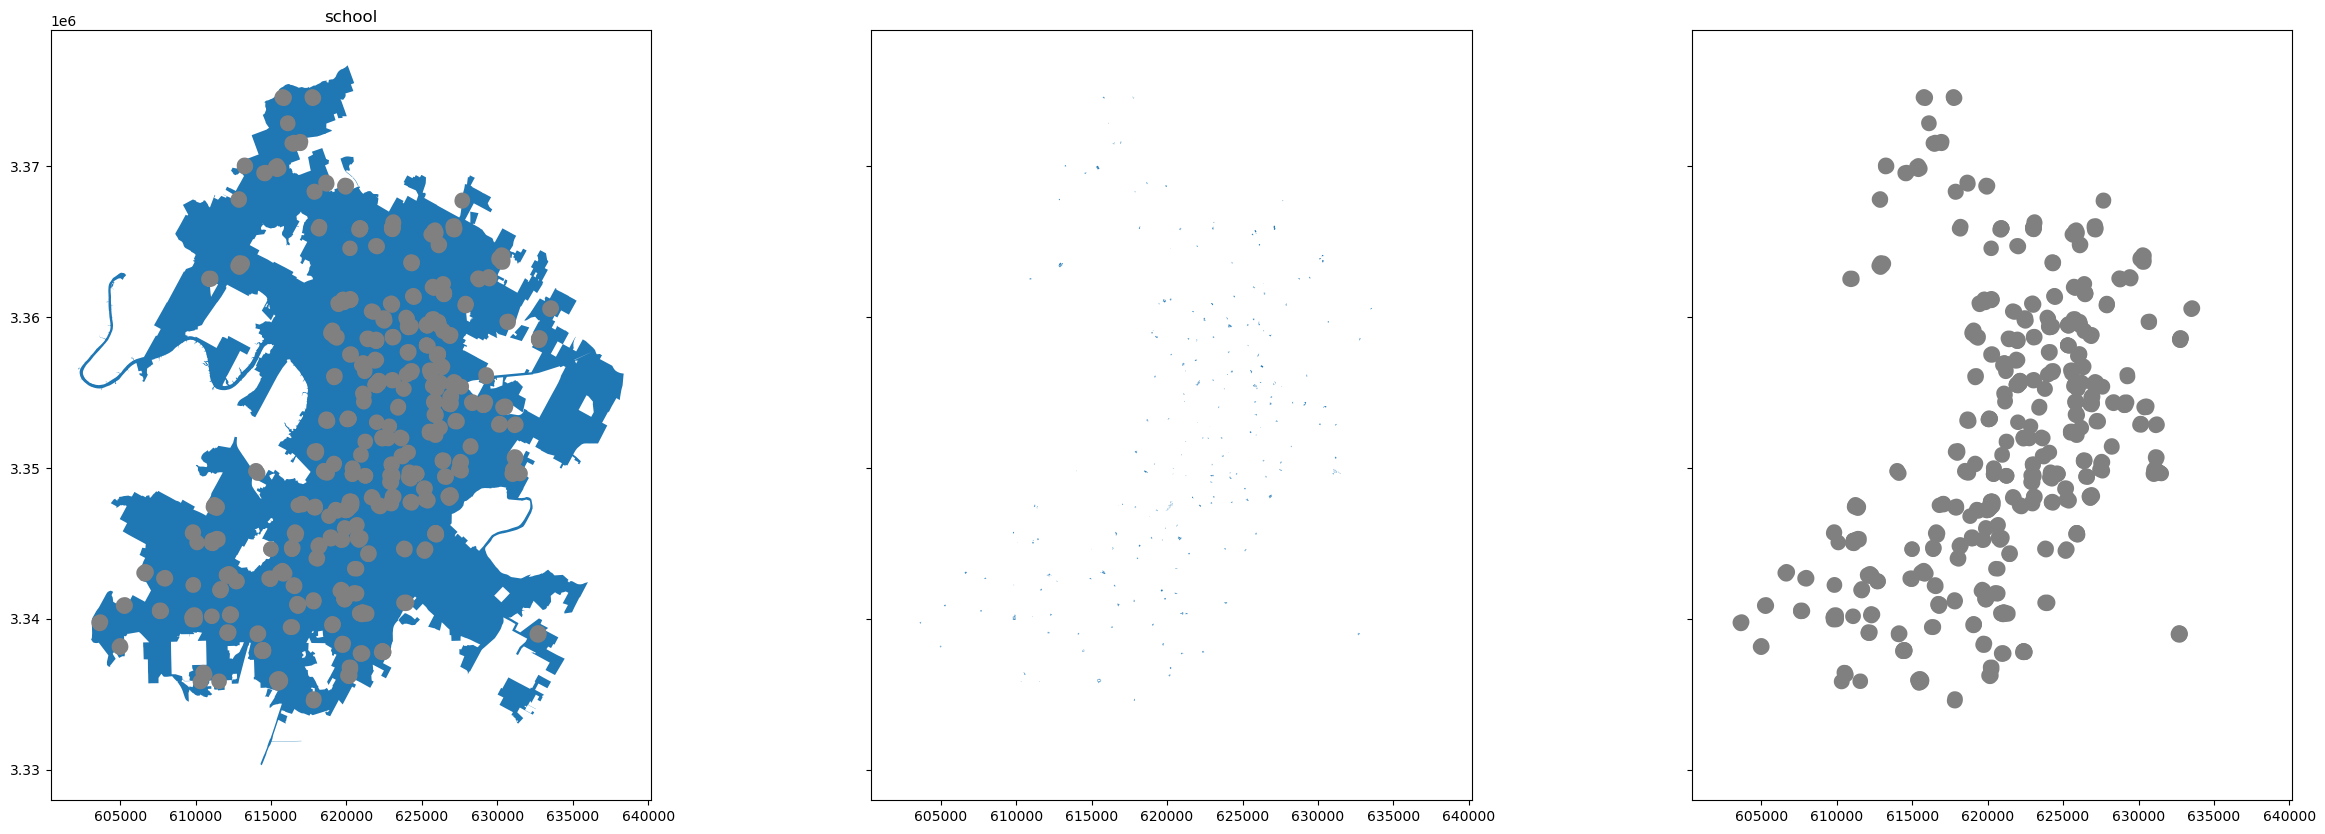

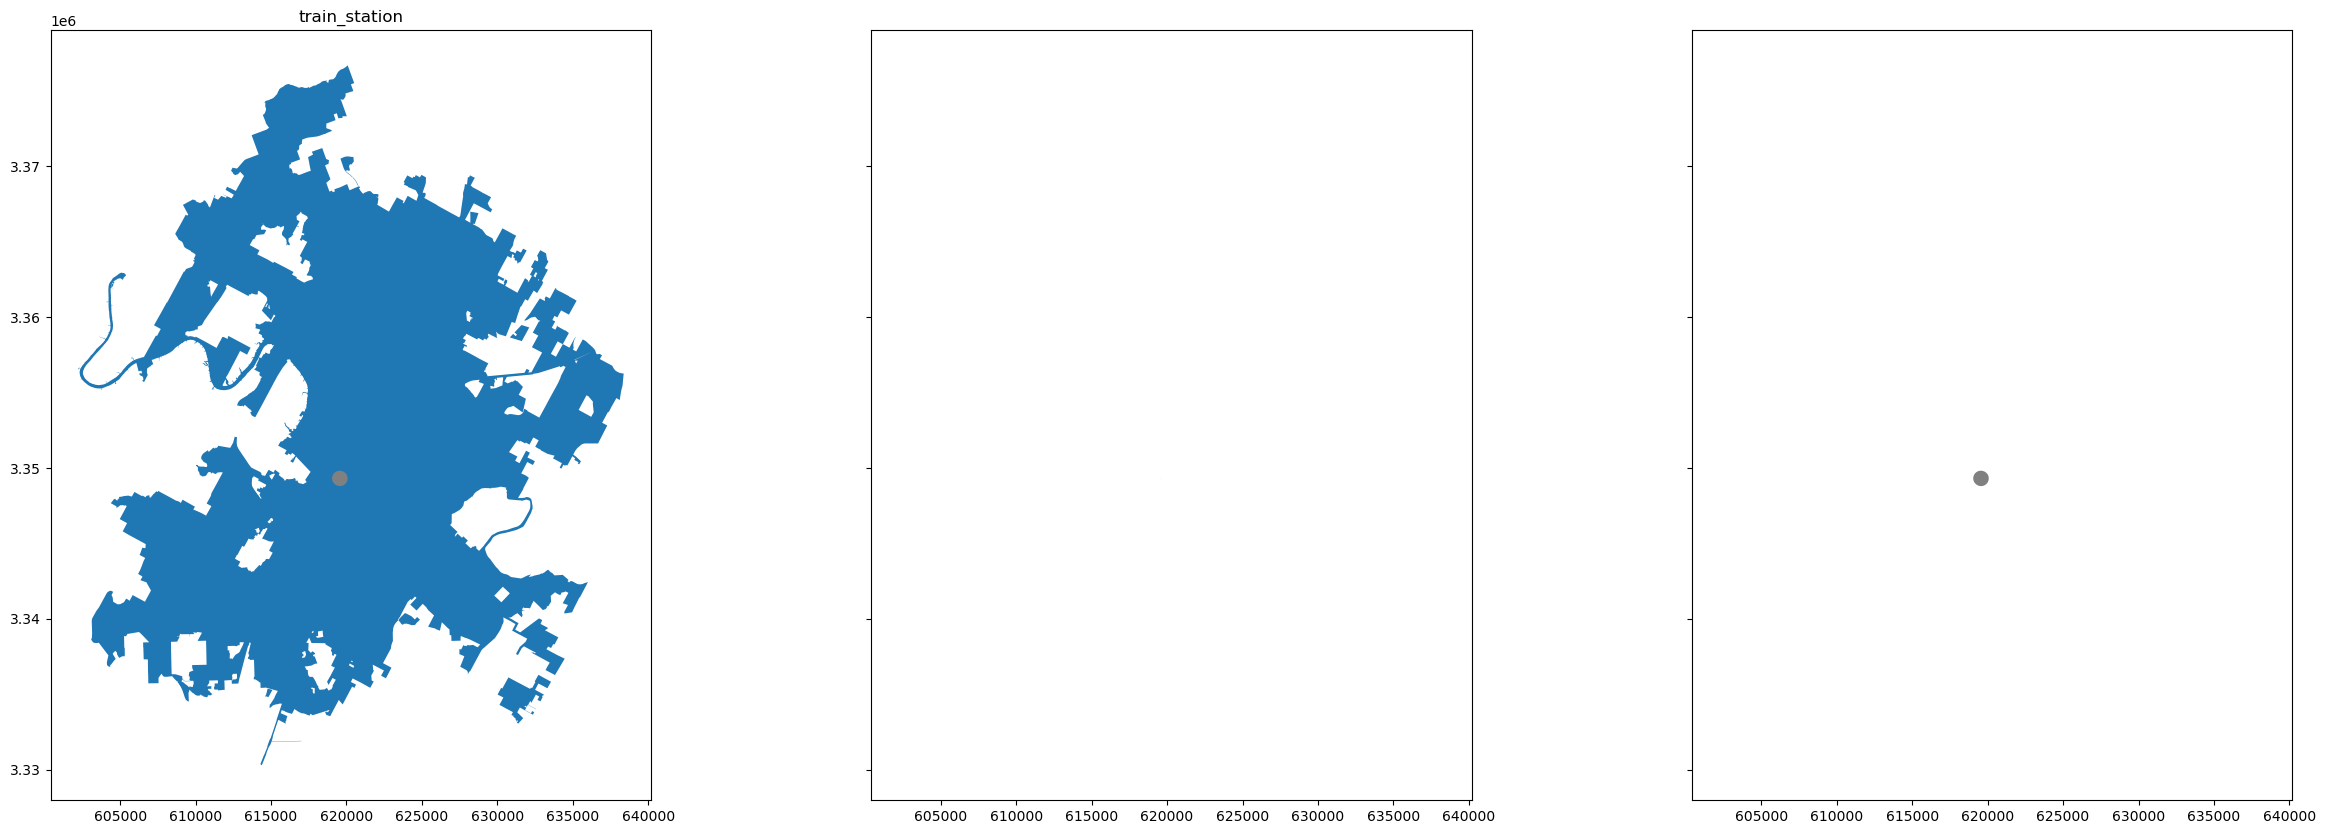

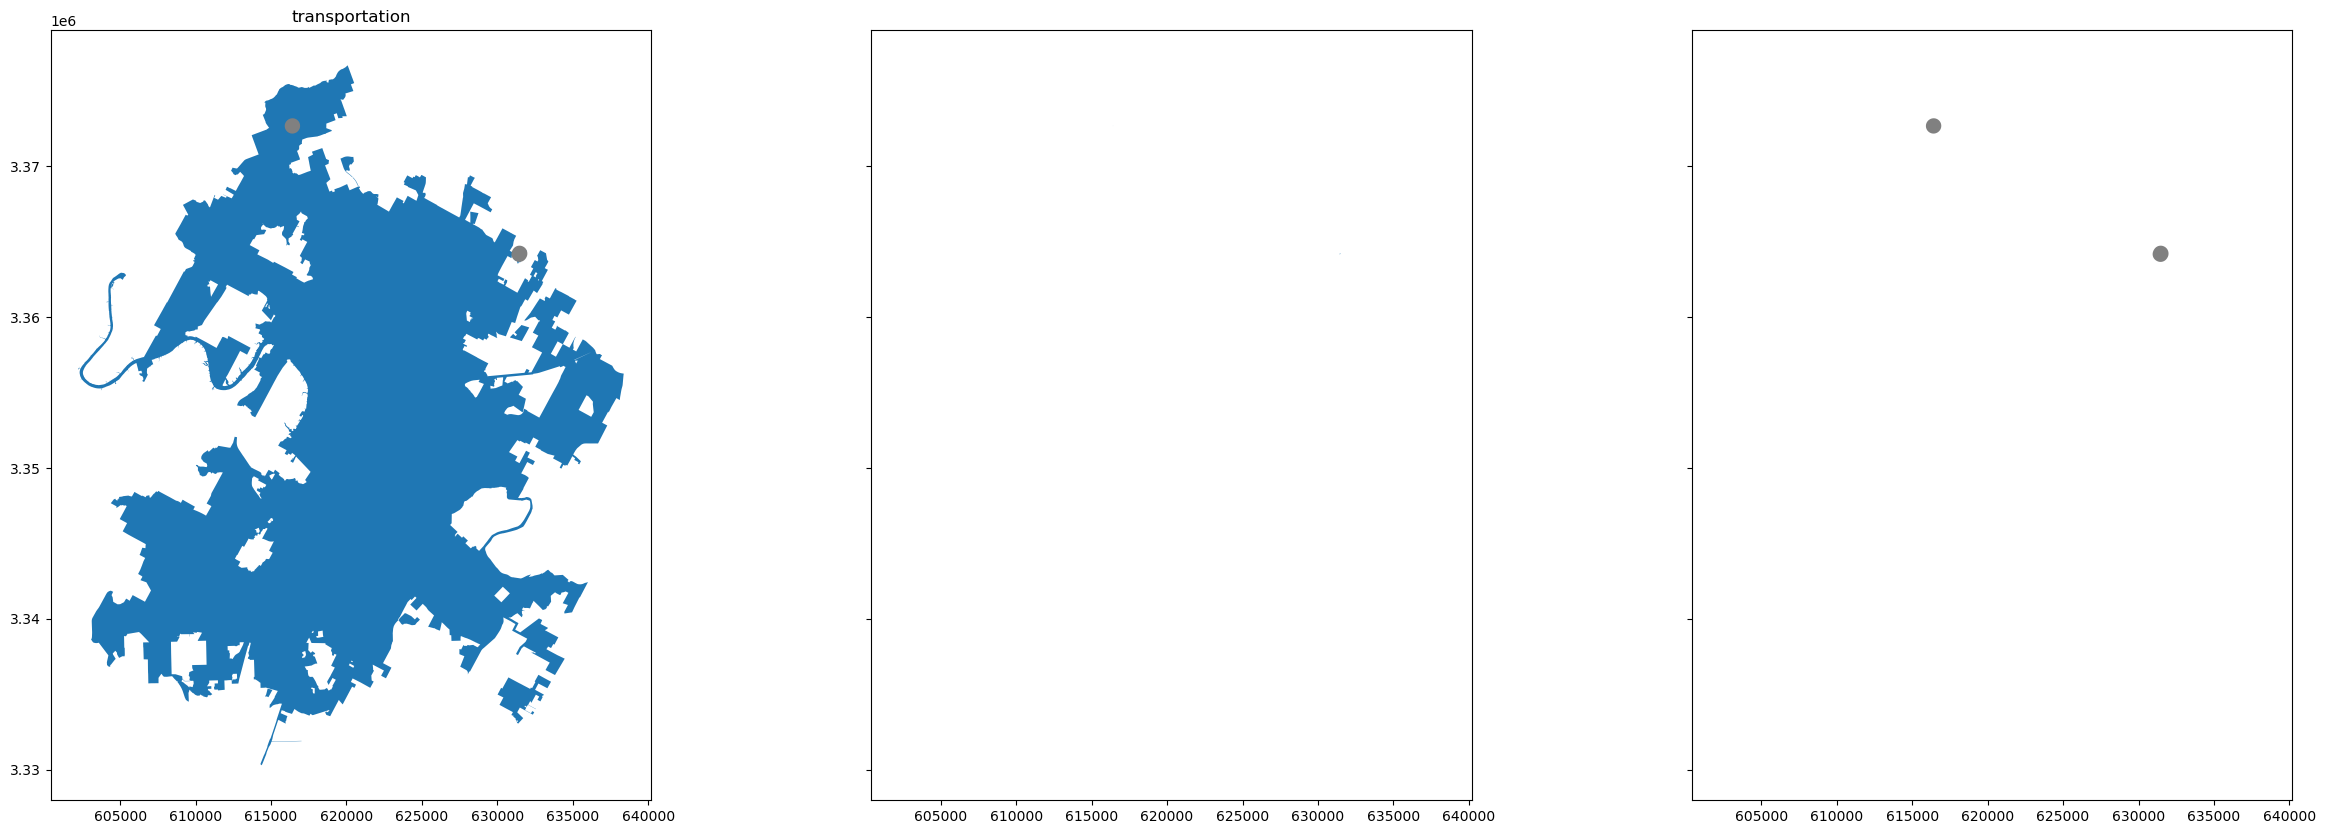

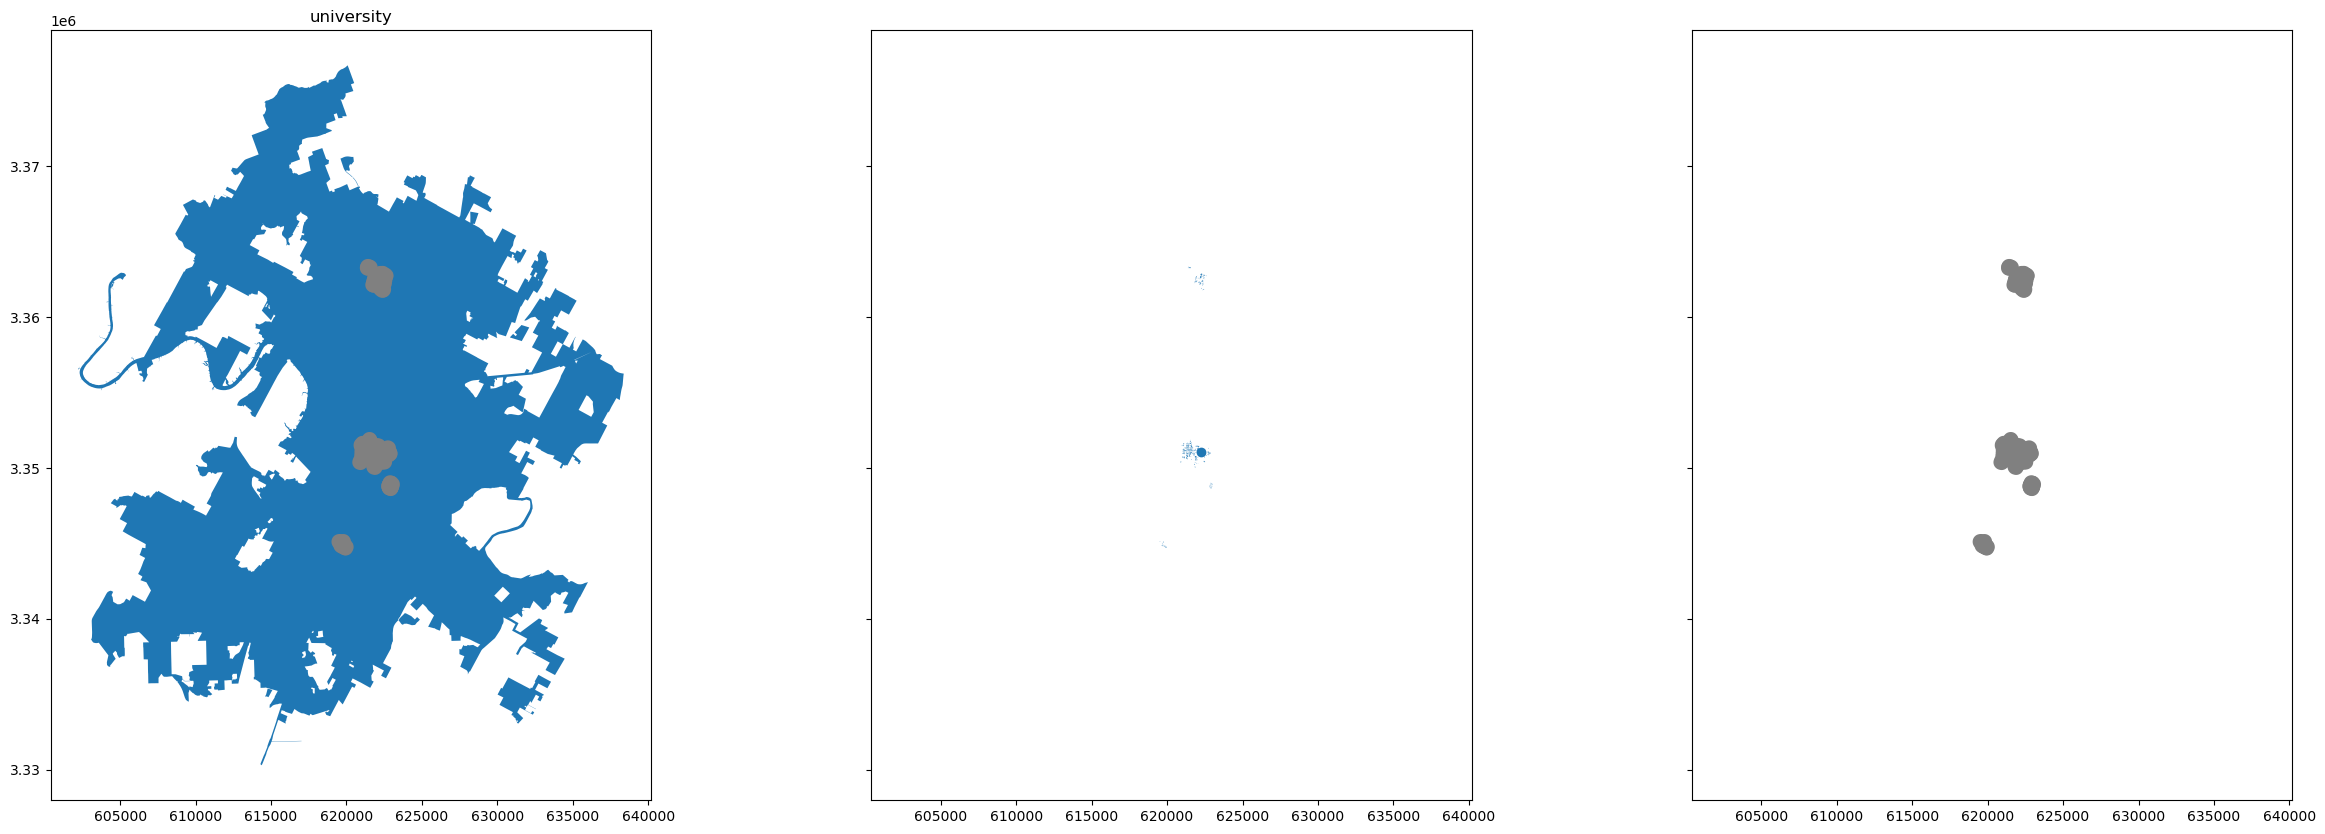

In [93]:
#, ("building", "commercial")
#                                     tag-list:   key, value                                aeroway is a top-level key (aka, top-level tag, feature tag, primary tag)
#                                                                                                       aerodrome is the second level key
# list of primary : secondary keys that are of interest
#        building : apartment
#                 : hotel
#                 : residential
#                 : commercial
#                 : industrial 
#                 : office 
#                 : retail
#                 : supermarket
#                 : civic
#                 : college
#                 : government 
#                 : public 
#                 : school
#                 : train_station
#                 : transportation
#                 : university 
# 
# count the number of polygons for each of the secondary keys 
#airspace = Airspace(12, "Austin, Texas, USA", airspace_tag_list=[("building", "commercial"),  ]) #("building", "hospital"), ("aeroway", "aerodrome"),
airspace = Airspace(12,
                    "Austin, Texas, USA",
                    airspace_tag_list=[
                                        ("building", "commercial"),
                                        ("building", "hotel"),
                                        ("building", "residential"),
                                        ("building", "industrial"),
                                        ("building", "office"),
                                        ("building", "retail"),
                                        ("building", "civic"),
                                        ("building", "college"),
                                        ("building", "government"),
                                        ("building", "public"),
                                        ("building", "school"),
                                        ("building", "train_station"),
                                        ("building", "transportation"),
                                        ("building", "university"),
                                        # ("building", "supermarket"), <- one of the tags which is not valid anymore in OSMNX
                                    ]
)
# airspace.location_utm_gdf.plot()



for tag_value in airspace.location_tags.keys():
            # Draw actual restricted areas
            print(f'TAG VALUE: {tag_value}, {len(airspace.location_utm[tag_value])}')
            fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, sharex=True, figsize=(30,10))
            # Austin map
            airspace.location_utm_gdf.plot(ax=ax1)
            ax1.set_title(f'{tag_value}')
            # polygon
            airspace.location_utm[tag_value].plot(ax=ax2)
            # Austin + Buffer
            airspace.location_utm_buffer[tag_value].plot(ax=ax1, color='gray')
            # Buffer 
            airspace.location_utm_buffer[tag_value].plot(ax=ax3, color='gray')



In [61]:
df_commercial = airspace.location_utm["commercial"]
df_office = airspace.location_utm["office"]

df_commercial['in_df_office'] = df_commercial.geometry.isin(df_office.geometry)

df_commercial['topo_eq_df_office'] = df_commercial.geometry.apply(
    lambda geom: any(geom.equals(other) for other in df_office.geometry)
)

df_commercial['topo_eq_df_office'].any()

False